# Coursework 3

## CIFAR 10

#### imports + data

In [2]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
%matplotlib inline

# import data providers
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)
mini_train_data = CIFAR10DataProvider('train', batch_size=50, input_num=10000)
mini_valid_data = CIFAR10DataProvider('valid', batch_size=50, input_num=2000)

In [3]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, weights=None):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

This set of experiments explore the improvement in performance when changing the learning rule of the NN to classify objects in the CIFAR 100 dataset

In [4]:
# ----- NETWORK DEFINITION ------------

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden1 = 400
num_hidden2 = 200

# --- define NN ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden1)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden1, num_hidden2)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, num_hidden2, train_data.num_classes, tf.identity)
# --- define error computation ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

# Performance with different Learning rules

### Simple Gradiant Descent

#### hyperparameter search: eta

---- Eta=0.0001 ----
                 err(valid)=2.20 acc(valid)=0.18
                 err(valid)=2.13 acc(valid)=0.23
                 err(valid)=2.08 acc(valid)=0.25
                 err(valid)=2.05 acc(valid)=0.27
                 err(valid)=2.02 acc(valid)=0.28
                 err(valid)=2.00 acc(valid)=0.29
                 err(valid)=1.99 acc(valid)=0.29
                 err(valid)=1.97 acc(valid)=0.30
                 err(valid)=1.96 acc(valid)=0.31
                 err(valid)=1.95 acc(valid)=0.32
                 err(valid)=1.94 acc(valid)=0.32
                 err(valid)=1.93 acc(valid)=0.32
                 err(valid)=1.93 acc(valid)=0.33
                 err(valid)=1.92 acc(valid)=0.33
                 err(valid)=1.91 acc(valid)=0.33
                 err(valid)=1.90 acc(valid)=0.34
                 err(valid)=1.90 acc(valid)=0.34
                 err(valid)=1.89 acc(valid)=0.34
                 err(valid)=1.89 acc(valid)=0.35
                 err(valid)=1.88 acc(valid)=0.34

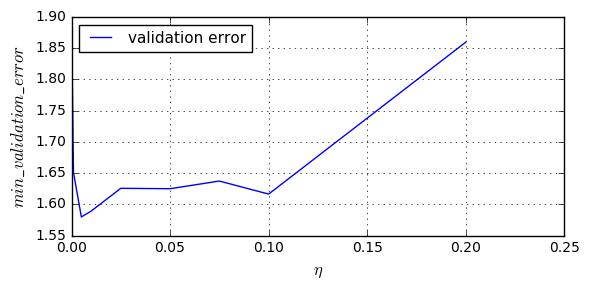

In [5]:

learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.5]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_search_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates, 
              eta_search_errors, label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('gd_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_simple_grad_descent = val_mins[0][0]

### Momentum Learning Rule

#### Eta search

---- Eta=1e-05 ----
                 err(valid)=2.21 acc(valid)=0.19
                 err(valid)=2.13 acc(valid)=0.23
                 err(valid)=2.09 acc(valid)=0.25
                 err(valid)=2.05 acc(valid)=0.26
                 err(valid)=2.02 acc(valid)=0.27
                 err(valid)=2.00 acc(valid)=0.28
                 err(valid)=1.98 acc(valid)=0.29
                 err(valid)=1.97 acc(valid)=0.29
                 err(valid)=1.96 acc(valid)=0.29
                 err(valid)=1.95 acc(valid)=0.30
                 err(valid)=1.94 acc(valid)=0.31
                 err(valid)=1.93 acc(valid)=0.31
                 err(valid)=1.92 acc(valid)=0.32
                 err(valid)=1.91 acc(valid)=0.32
                 err(valid)=1.91 acc(valid)=0.32
                 err(valid)=1.90 acc(valid)=0.32
                 err(valid)=1.90 acc(valid)=0.32
                 err(valid)=1.89 acc(valid)=0.33
                 err(valid)=1.88 acc(valid)=0.33
                 err(valid)=1.88 acc(valid)=0.33


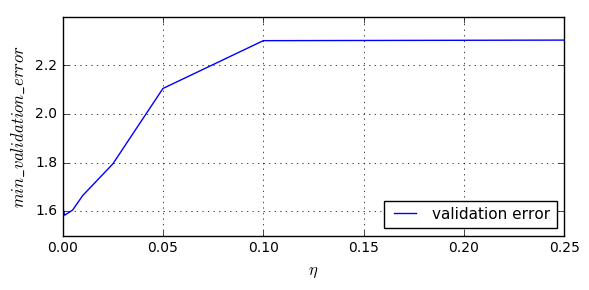

In [6]:
learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_momentum_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates, eta_momentum_errors, label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('momentum_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_momentum_rule = val_mins[0][0]

#### Alpha search

---- Alpha=0.6 ----
                 err(valid)=1.88 acc(valid)=0.33
                 err(valid)=1.80 acc(valid)=0.38
                 err(valid)=1.76 acc(valid)=0.38
                 err(valid)=1.73 acc(valid)=0.40
                 err(valid)=1.72 acc(valid)=0.40
                 err(valid)=1.69 acc(valid)=0.40
                 err(valid)=1.68 acc(valid)=0.41
                 err(valid)=1.66 acc(valid)=0.41
                 err(valid)=1.64 acc(valid)=0.43
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.61 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.45
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.45
                 err(valid)=1.59 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.58 acc(valid)=0.46
                 err(valid)=1.57 acc(valid)=0.46
                 err(valid)=1.58 acc(valid)=0.45


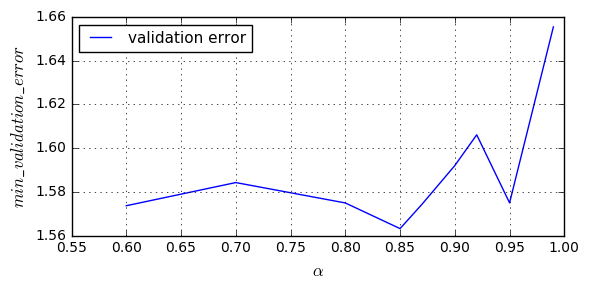

In [9]:
momentums = [0.6, 0.7, 0.8, 0.85, 0.87, 0.9, 0.92, 0.95, 0.99]

val_mins = []

for momentum in momentums:

    print("---- Alpha="+str(momentum)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.MomentumOptimizer(learning_rate=eta_momentum_rule, momentum=momentum).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(momentum, min(validation_errors))]

_, alpha_momentum_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER Alpha
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(momentums, alpha_momentum_errors, label='validation error')

ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('Momentum_alpha_search.pdf') 

print("------  Alpha search  --------")
print("minimum validation error is {} for Alpha={}".format(val_mins[0][1], val_mins[0][0]))
alpha_momentum_rule = val_mins[0][0]

### RMSProp


#### eta search

---- Eta=1e-05 ----
                 err(valid)=1.92 acc(valid)=0.32
                 err(valid)=1.83 acc(valid)=0.35
                 err(valid)=1.79 acc(valid)=0.37
                 err(valid)=1.75 acc(valid)=0.39
                 err(valid)=1.72 acc(valid)=0.39
                 err(valid)=1.71 acc(valid)=0.39
                 err(valid)=1.69 acc(valid)=0.40
                 err(valid)=1.67 acc(valid)=0.41
                 err(valid)=1.66 acc(valid)=0.42
                 err(valid)=1.65 acc(valid)=0.42
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.63 acc(valid)=0.42
                 err(valid)=1.62 acc(valid)=0.43
                 err(valid)=1.62 acc(valid)=0.43
                 err(valid)=1.61 acc(valid)=0.44
                 err(valid)=1.61 acc(valid)=0.43
                 err(valid)=1.60 acc(valid)=0.43
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.58 acc(valid)=0.44
                 err(valid)=1.59 acc(valid)=0.44


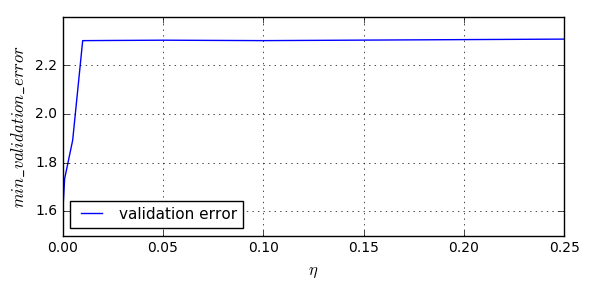

In [11]:
learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=0.9).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_rmsprop_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(learning_rates, eta_rmsprop_errors, label='validation error')

ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('rmsprop_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_RMSProp_rule = 0.0001

#### beta search

---- Beta=0.60001 ----
                 err(valid)=1.81 acc(valid)=0.37
                 err(valid)=1.77 acc(valid)=0.36
                 err(valid)=1.70 acc(valid)=0.42
                 err(valid)=1.66 acc(valid)=0.42
                 err(valid)=1.67 acc(valid)=0.43
                 err(valid)=1.66 acc(valid)=0.45
                 err(valid)=1.64 acc(valid)=0.46
                 err(valid)=1.68 acc(valid)=0.44
                 err(valid)=1.79 acc(valid)=0.43
                 err(valid)=1.75 acc(valid)=0.43
                 err(valid)=1.82 acc(valid)=0.44
                 err(valid)=1.82 acc(valid)=0.45
                 err(valid)=2.09 acc(valid)=0.43
                 err(valid)=1.84 acc(valid)=0.46
                 err(valid)=2.03 acc(valid)=0.44
                 err(valid)=1.94 acc(valid)=0.47
                 err(valid)=2.38 acc(valid)=0.42
                 err(valid)=2.16 acc(valid)=0.46
                 err(valid)=2.28 acc(valid)=0.46
                 err(valid)=2.36 acc(valid)=0.

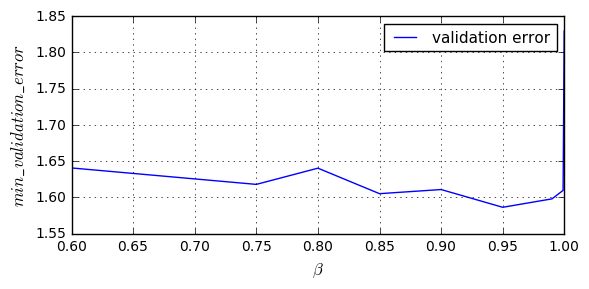

In [14]:
decays = [0.60001, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999]
eta_RMSProp_rule = 1e-05
val_mins = []

for decay in decays:

    print("---- Beta="+str(decay)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=decay).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(decay, min(validation_errors))]

_, beta_rmsprop_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(decays, beta_rmsprop_errors, label='validation error')

ax.set_xlabel('$\\beta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('rmsprop_beta_search.pdf') 

print("------  beta search  --------")
print("minimum validation error is {} for beta={}".format(val_mins[0][1], val_mins[0][0]))
beta_RMSProp_rule = val_mins[0][0]

### ADAM

#### eta search

---- Eta=1e-05 ----
                 err(valid)=1.91 acc(valid)=0.32
                 err(valid)=1.84 acc(valid)=0.35
                 err(valid)=1.79 acc(valid)=0.36
                 err(valid)=1.76 acc(valid)=0.39
                 err(valid)=1.73 acc(valid)=0.38
                 err(valid)=1.71 acc(valid)=0.40
                 err(valid)=1.70 acc(valid)=0.40
                 err(valid)=1.68 acc(valid)=0.41
                 err(valid)=1.66 acc(valid)=0.42
                 err(valid)=1.64 acc(valid)=0.42
                 err(valid)=1.64 acc(valid)=0.43
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.62 acc(valid)=0.43
                 err(valid)=1.61 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.45
                 err(valid)=1.60 acc(valid)=0.45
                 err(valid)=1.58 acc(valid)=0.44
                 err(valid)=1.58 acc(valid)=0.45
                 err(valid)=1.58 acc(valid)=0.46


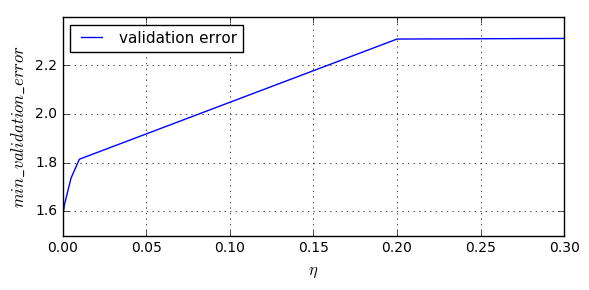

In [15]:
learning_rates = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.2, 0.3]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_adam_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates, eta_adam_errors, label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('adam_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_adam_rule = val_mins[0][0]

#### beta1 search

---- Beta1=0.85 ----
                 err(valid)=1.90 acc(valid)=0.34
                 err(valid)=1.83 acc(valid)=0.36
                 err(valid)=1.78 acc(valid)=0.38
                 err(valid)=1.75 acc(valid)=0.39
                 err(valid)=1.72 acc(valid)=0.40
                 err(valid)=1.71 acc(valid)=0.40
                 err(valid)=1.68 acc(valid)=0.41
                 err(valid)=1.67 acc(valid)=0.41
                 err(valid)=1.66 acc(valid)=0.42
                 err(valid)=1.65 acc(valid)=0.42
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.61 acc(valid)=0.43
                 err(valid)=1.62 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.61 acc(valid)=0.44
                 err(valid)=1.59 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.59 acc(valid)=0.44
                 err(valid)=1.58 acc(valid)=0.45

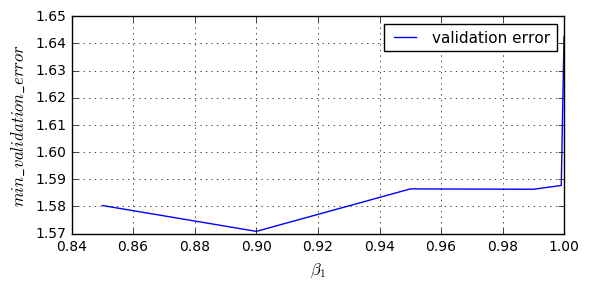

In [16]:
beta1s = [0.85, 0.9, 0.95, 0.99, 0.999, 0.9999]

val_mins = []

for beta in beta1s:

    print("---- Beta1="+str(beta)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=eta_adam_rule, beta1=beta, beta2=0.999).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(beta, min(validation_errors))]

_, beta1_adam_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(beta1s, beta1_adam_errors, label='validation error')

ax.set_xlabel('$\\beta_1$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('adam_beta1_search.pdf') 

print("------  beta1 search  --------")
print("minimum validation error is {} for beta2={}".format(val_mins[0][1], val_mins[0][0]))
beta1_adam_rule = val_mins[0][0]

#### beta2 search

---- Beta2=0.85 ----
                 err(valid)=1.92 acc(valid)=0.32
                 err(valid)=1.85 acc(valid)=0.34
                 err(valid)=1.81 acc(valid)=0.37
                 err(valid)=1.77 acc(valid)=0.37
                 err(valid)=1.75 acc(valid)=0.39
                 err(valid)=1.74 acc(valid)=0.39
                 err(valid)=1.70 acc(valid)=0.40
                 err(valid)=1.68 acc(valid)=0.41
                 err(valid)=1.67 acc(valid)=0.41
                 err(valid)=1.66 acc(valid)=0.43
                 err(valid)=1.65 acc(valid)=0.42
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.63 acc(valid)=0.43
                 err(valid)=1.62 acc(valid)=0.43
                 err(valid)=1.61 acc(valid)=0.44
                 err(valid)=1.61 acc(valid)=0.43
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.44
                 err(valid)=1.60 acc(valid)=0.45
                 err(valid)=1.58 acc(valid)=0.45

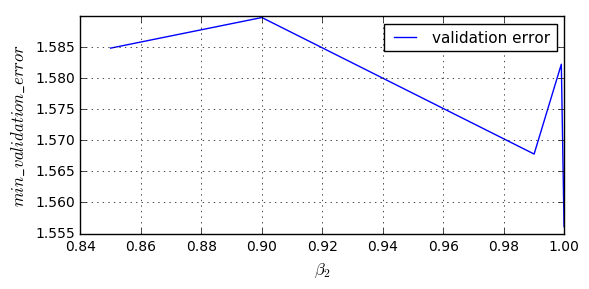

In [17]:
beta2s = [0.85, 0.9, 0.99, 0.999, 0.9999]

val_mins = []

for beta in beta2s:

    print("---- Beta2="+str(beta)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=eta_adam_rule, beta1=beta1_adam_rule, beta2=beta).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(beta, min(validation_errors))]

_, beta2_adam_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(beta2s, beta2_adam_errors, label='validation error')
ax.set_xlabel('$\\beta_2$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('adam_beta2_search.pdf') 

print("------  beta2 search  --------")
print("minimum validation error is {} for beta2={}".format(val_mins[0][1], val_mins[0][0]))
beta2_adam_rule = val_mins[0][0]

### Learning Rules Comparison

---------- Gradient Descent-----------
                 err(valid)=1.609085 acc(valid)=0.437800
                 err(valid)=1.557959 acc(valid)=0.450400
                 err(valid)=1.509380 acc(valid)=0.468600
                 err(valid)=1.439818 acc(valid)=0.496800
                 err(valid)=1.421330 acc(valid)=0.499500
                 err(valid)=1.426714 acc(valid)=0.499300
                 err(valid)=1.394113 acc(valid)=0.509300
                 err(valid)=1.390978 acc(valid)=0.516500
                 err(valid)=1.398771 acc(valid)=0.516500
                 err(valid)=1.377287 acc(valid)=0.525300
                 err(valid)=1.428822 acc(valid)=0.517800
                 err(valid)=1.436568 acc(valid)=0.510400
                 err(valid)=1.435682 acc(valid)=0.519300
                 err(valid)=1.449531 acc(valid)=0.519700
                 err(valid)=1.562143 acc(valid)=0.497800
                 err(valid)=1.475227 acc(valid)=0.521300
                 err(valid)=1.470754 acc(valid)=0

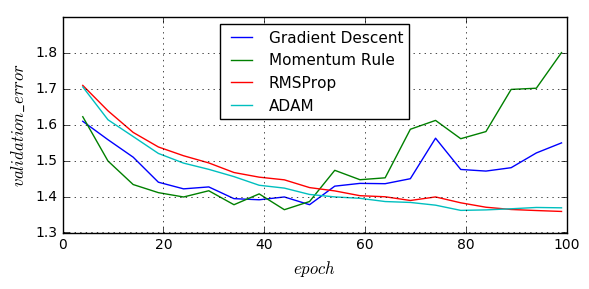

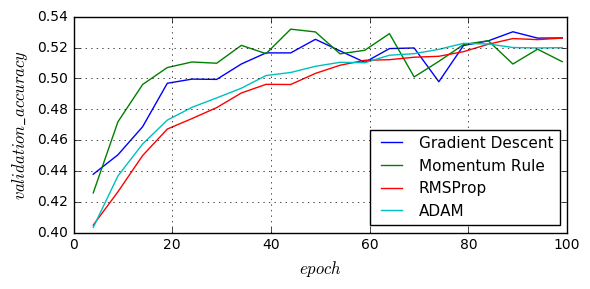

In [18]:
import time

# --------------- GRADIENT DESCENT ----------------
print('---------- Gradient Descent-----------')
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=eta_simple_grad_descent).minimize(error)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
epochs = []
grad_descent_valid_error = []
grad_descent_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        
        epochs += [e]
        grad_descent_valid_error += [valid_error]
        grad_descent_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
grad_descent_time = time.time() - t
# --------------- MOMENTUM rule ----------------
print('---------- Momentum Rule-----------')
with tf.name_scope('train'):
    train_step = tf.train.MomentumOptimizer(learning_rate=eta_momentum_rule, momentum=alpha_momentum_rule).minimize(error)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
momentum_valid_error = []
momentum_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        momentum_valid_error += [valid_error]
        momentum_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
momentum_time = time.time() - t

# --------------- RMSProp rule ----------------
print('---------- RMSPror Rule-----------')
with tf.name_scope('train'):
    train_step = tf.train.RMSPropOptimizer(learning_rate=eta_RMSProp_rule, decay=beta_RMSProp_rule).minimize(error)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
rmsprop_valid_error = []
rmsprop_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        rmsprop_valid_error += [valid_error]
        rmsprop_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
rmsprop_time = time.time() - t

# --------------- Adam rule ----------------
print('---------- Adam Rule-----------')
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=eta_adam_rule, beta1=beta1_adam_rule, beta2=beta2_adam_rule).minimize(error)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
adam_valid_error = []
adam_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        adam_valid_error += [valid_error]
        adam_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
adam_time = time.time() - t



#---------- errors -------
fig_size = (6, 3) 
fig1 = plt.figure(figsize=fig_size)
ax = fig1.add_subplot(1, 1, 1)

ax.plot(epochs, grad_descent_valid_error, label='Gradient Descent')
ax.plot(epochs, momentum_valid_error, label='Momentum Rule')
ax.plot(epochs, rmsprop_valid_error, label='RMSProp')
ax.plot(epochs, adam_valid_error, label='ADAM')

ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig1.tight_layout() 
fig1.savefig('opt_rules_error_comparison.pdf') 

#---------- accuracies -------
 
fig2 = plt.figure(figsize=fig_size)
ax = fig2.add_subplot(1, 1, 1)

ax.plot(epochs, grad_descent_valid_acc, label='Gradient Descent')
ax.plot(epochs, momentum_valid_acc, label='Momentum Rule')
ax.plot(epochs, rmsprop_valid_acc, label='RMSProp')
ax.plot(epochs, adam_valid_acc, label='ADAM')

ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_accuracy$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig2.tight_layout() 
fig2.savefig('opt_rules_acc_comparison.pdf') 

print("-----GRADIENT DESCENT-------")
print("min validation error: "+str(min(grad_descent_valid_error)))
print("max accuracy: "+str(max(grad_descent_valid_acc)))
print("training time: "+str(grad_descent_time))
print("-----MOMENTUM RULE-------")
print("min validation error: "+str(min(momentum_valid_error)))
print("max accuracy: "+str(max(momentum_valid_acc)))
print("training time: "+str(momentum_time))
print("-----RMSPROP RULE-------")
print("min validation error: "+str(min(rmsprop_valid_error)))
print("max accuracy: "+str(max(rmsprop_valid_acc)))
print("training time: "+str(rmsprop_time))
print("-----ADAM RULE-------")
print("min validation error: "+str(min(adam_valid_error)))
print("max accuracy: "+str(max(adam_valid_acc)))
print("training time: "+str(adam_time))

#  Autoencoders vs Drop-out

## Autoencoder

#### Auto-encoder network for hidden layer 1

In [19]:
# ----- AUTOENCODER NETWORK FOR HIDDEN LAYER 1 ------------

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

input_dim = train_data.inputs.shape[1]
output_dim = train_data.num_classes
hid1_dim = 400
hid2_dim = 200

# --- define NN for pretraining layer 1 ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, input_dim, hid1_dim)
with tf.name_scope('output-pretrain_layer1'):
    outputs_pt_layer_1 = fully_connected_layer(hidden_1, hid1_dim, input_dim, tf.identity)
# --- define error computation ---
with tf.name_scope('error_pretrain_layer1'):
    error_pt_layer_1 = tf.reduce_mean(tf.pow(outputs_pt_layer_1-inputs, 2))
# --- define training rule ---
with tf.name_scope('pretrain_layer1'):
    train_step_layer_1 = tf.train.GradientDescentOptimizer(learning_rate=0.25).minimize(error_pt_layer_1)
    
    
# --- define NN for pretraining layer 2 ---
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, hid1_dim, hid2_dim)
with tf.name_scope('output-pretrain_layer2'):
    outputs_pt_layer_2 = fully_connected_layer(hidden_2, hid2_dim, input_dim, tf.identity)
# --- define error computation ---
with tf.name_scope('error_pretrain_layer2'):
    error_pt_layer_2 = tf.reduce_mean(tf.pow(outputs_pt_layer_2-inputs, 2))
# --- define training rule ---
with tf.name_scope('pretrain_layer1'):
    train_step_layer_2 = tf.train.GradientDescentOptimizer(learning_rate=0.25).minimize(error_pt_layer_2)
    
# --- define NN ---
with tf.name_scope('output'):
    outputs = fully_connected_layer(hidden_2, hid2_dim, output_dim, tf.identity)
# --- define training rule ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.005).minimize(error)
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

In [20]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
layer_1_trainerros = []
layer_1_valerrors = []
# PRETRAIN LAYER 1
for e in range(100):
    # training step
    train_error = 0.
    for input_batch, _ in train_data:
        _, batch_error = sess.run(
            [train_step_layer_1, error_pt_layer_1], 
            feed_dict={inputs: input_batch})
#         print(batch_error)
        train_error += batch_error
    train_error /= train_data.num_batches
    layer_1_trainerros += [train_error]
    print('                 err(train)={0:.4f}'.format(train_error))
    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        for input_batch, _ in valid_data:
            batch_error = sess.run(
                error_pt_layer_1, 
                feed_dict={inputs: input_batch})
            valid_error += batch_error
        valid_error /= valid_data.num_batches
        layer_1_valerrors += [valid_error]
        print('                 err(valid)={0:.4f}'.format(valid_error))
    # early stopping
    if len(layer_1_valerrors)>1 and layer_1_valerrors[-2]<layer_1_valerrors[-1]:
        break


                 err(train)=0.0609
                 err(train)=0.0433
                 err(train)=0.0379
                 err(train)=0.0344
                 err(train)=0.0321
                 err(valid)=0.0310
                 err(train)=0.0304
                 err(train)=0.0288
                 err(train)=0.0275
                 err(train)=0.0262
                 err(train)=0.0252
                 err(valid)=0.0246
                 err(train)=0.0243
                 err(train)=0.0235
                 err(train)=0.0228
                 err(train)=0.0222
                 err(train)=0.0217
                 err(valid)=0.0214
                 err(train)=0.0213
                 err(train)=0.0209
                 err(train)=0.0205
                 err(train)=0.0202
                 err(train)=0.0198
                 err(valid)=0.0196
                 err(train)=0.0195
                 err(train)=0.0192
                 err(train)=0.0189
                 err(train)=0.0186
                 err

------  layer1 search  --------
minimum validation error is 0.011212116214446724


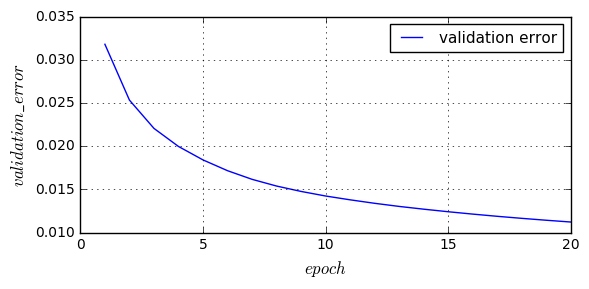

In [83]:
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(layer_1_valerrors)+1), layer_1_valerrors, label='validation error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('autoencoder_layer1.pdf') 

print("------  layer1 search  --------")
print("minimum validation error is {}".format(min(layer_1_valerrors)))

#### Auto-encoder network for hidden layer 2

In [21]:
# PRETRAIN LAYER 2

layer_2_trainerros = []
layer_2_valerrors = []
for e in range(70):
    # training step
    train_error = 0.
    for input_batch, _ in train_data:
        _, batch_error = sess.run(
            [train_step_layer_2, error_pt_layer_2], 
            feed_dict={inputs: input_batch})
#         print(batch_error)
        train_error += batch_error
    train_error /= train_data.num_batches
    layer_2_trainerros += [train_error]
    print('                 err(train)={0:.4f}'.format(train_error))
    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        for input_batch, _ in valid_data:
            batch_error = sess.run(
                error_pt_layer_2, 
                feed_dict={inputs: input_batch})
            valid_error += batch_error
        valid_error /= valid_data.num_batches
        layer_2_valerrors += [valid_error]
        print('                 err(valid)={0:.4f}'.format(valid_error))
    # early stopping
    if len(layer_2_valerrors)>1 and layer_2_valerrors[-2]<layer_2_valerrors[-1]:
        break


                 err(train)=0.0604
                 err(train)=0.0440
                 err(train)=0.0394
                 err(train)=0.0357
                 err(train)=0.0333
                 err(valid)=0.0321
                 err(train)=0.0315
                 err(train)=0.0302
                 err(train)=0.0290
                 err(train)=0.0279
                 err(train)=0.0268
                 err(valid)=0.0262
                 err(train)=0.0258
                 err(train)=0.0250
                 err(train)=0.0242
                 err(train)=0.0235
                 err(train)=0.0229
                 err(valid)=0.0226
                 err(train)=0.0224
                 err(train)=0.0219
                 err(train)=0.0215
                 err(train)=0.0212
                 err(train)=0.0209
                 err(valid)=0.0206
                 err(train)=0.0206
                 err(train)=0.0203
                 err(train)=0.0200
                 err(train)=0.0198
                 err

------  layer2 search  --------
minimum validation error is 0.014393281168304383


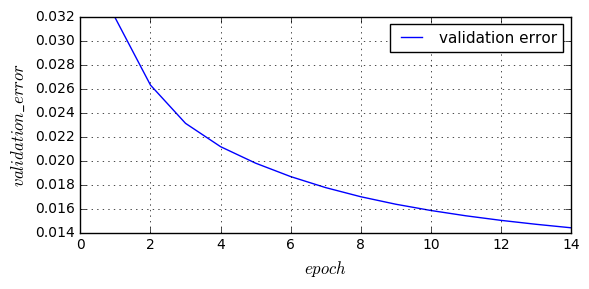

In [85]:
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(layer_2_valerrors)+1), layer_2_valerrors, label='validation error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('autoencoder_layer2.pdf') 

print("------  layer2 search  --------")
print("minimum validation error is {}".format(min(layer_2_valerrors)))

#### Autoencoder final training

In [22]:
trainerros = []
trainaccs = []
valerrors = []
valaccs = []
validation_errors = []
# TRAIN NETWORK
for e in range(100):
    # training step
    train_error = 0.
    train_accuracy = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_accuracy = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        train_error += batch_error
        train_accuracy += batch_accuracy
    train_error /= train_data.num_batches
    train_accuracy /= train_data.num_batches
    trainerros += [train_error]
    trainaccs += [train_accuracy]
    print('                 err(train)={0:.4f} acc(train)={1:.4f}'.format(train_error, train_accuracy))
    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_accuracy = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_accuracy
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        valerrors += [valid_error]
        valaccs += [valid_accuracy]
        print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'.format(valid_error, valid_accuracy))

                 err(train)=2.0822 acc(train)=0.2488
                 err(train)=1.8931 acc(train)=0.3268
                 err(train)=1.8283 acc(train)=0.3556
                 err(train)=1.7843 acc(train)=0.3717
                 err(train)=1.7496 acc(train)=0.3876
                 err(valid)=1.7509 acc(valid)=0.3799
                 err(train)=1.7203 acc(train)=0.3971
                 err(train)=1.6941 acc(train)=0.4040
                 err(train)=1.6697 acc(train)=0.4136
                 err(train)=1.6482 acc(train)=0.4202
                 err(train)=1.6276 acc(train)=0.4268
                 err(valid)=1.6366 acc(valid)=0.4270
                 err(train)=1.6082 acc(train)=0.4366
                 err(train)=1.5904 acc(train)=0.4420
                 err(train)=1.5727 acc(train)=0.4483
                 err(train)=1.5590 acc(train)=0.4512
                 err(train)=1.5432 acc(train)=0.4583
                 err(valid)=1.5781 acc(valid)=0.4487
                 err(train)=1.5308 acc(train)=

------  layer2 search  --------
minimum validation error is 1.3711723574995995
minimum validation acc is 0.5260000002384185


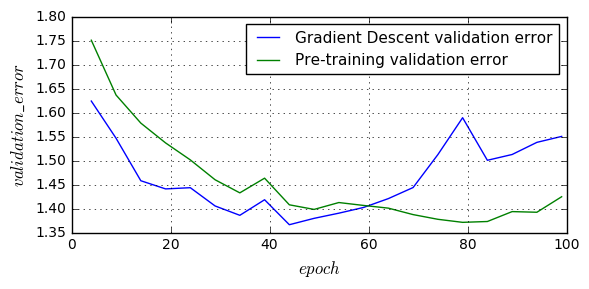

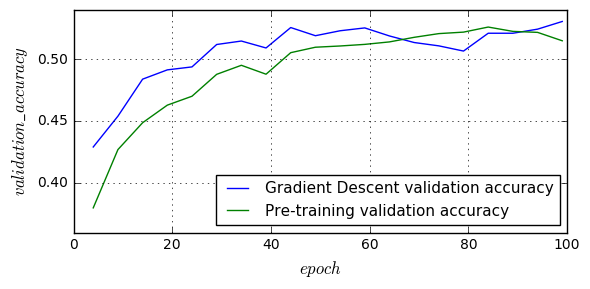

In [33]:
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(4, 100, 5), grad_descent_valid_error[:20], label='Gradient Descent validation error')
ax.plot(np.arange(4, 100, 5), valerrors, label='Pre-training validation error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('autoencoder_error.pdf') 

fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(4, 100, 5), grad_descent_valid_acc[:20], label='Gradient Descent validation accuracy')
ax.plot(np.arange(4, 100, 5), valaccs, label='Pre-training validation accuracy')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_accuracy$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('autoencoder_acc.pdf') 

print("------  layer2 search  --------")
print("minimum validation error is {}".format(min(valerrors)))
print("minimum validation acc is {}".format(max(valaccs)))

## Dropout

In [25]:
# ----- NETWORK DEFINITION ------------
keep_prob = tf.placeholder(tf.float32)
learning_rate = 0.005

tf.reset_default_graph

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden1 = 400
num_hidden2 = 200

# --- define NN ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = tf.nn.dropout(fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden1), keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2 = tf.nn.dropout(fully_connected_layer(hidden_1, num_hidden1, num_hidden2), keep_prob)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, num_hidden2, train_data.num_classes, tf.identity)
# --- define error computation ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
# --- define training rule ---
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(error)

In [26]:
import time as t
print("---- Dropout ----")

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

time = t.time()
dropout_validation_errors = []
dropout_validation_accs = []
for e in range(400):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, 
                       targets: target_batch,
                       keep_prob: 0.5})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, 
                           targets: target_batch,
                           keep_prob: 1.})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        dropout_validation_errors += [valid_error]
        dropout_validation_accs += [valid_accuracy]
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))

drop_out_time = t.time()-time

---- Dropout ----
                 err(valid)=1.804732 acc(valid)=0.372800
                 err(valid)=1.705976 acc(valid)=0.410500
                 err(valid)=1.645251 acc(valid)=0.423800
                 err(valid)=1.612637 acc(valid)=0.437900
                 err(valid)=1.587144 acc(valid)=0.448700
                 err(valid)=1.555661 acc(valid)=0.460000
                 err(valid)=1.525907 acc(valid)=0.467900
                 err(valid)=1.511238 acc(valid)=0.469500
                 err(valid)=1.493090 acc(valid)=0.484400
                 err(valid)=1.476160 acc(valid)=0.484900
                 err(valid)=1.467638 acc(valid)=0.485000
                 err(valid)=1.452178 acc(valid)=0.494200
                 err(valid)=1.442568 acc(valid)=0.492400
                 err(valid)=1.437230 acc(valid)=0.496500
                 err(valid)=1.412432 acc(valid)=0.503400
                 err(valid)=1.406611 acc(valid)=0.504700
                 err(valid)=1.394092 acc(valid)=0.507300
             

In [27]:
# ----- NETWORK DEFINITION ------------

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden1 = 400
num_hidden2 = 200

# --- define NN ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden1)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden1, num_hidden2)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, num_hidden2, train_data.num_classes, tf.identity)
# --- define error computation ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

In [28]:
# --------------- GRADIENT DESCENT ----------------
print('---------- Gradient Descent-----------')
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=eta_simple_grad_descent).minimize(error)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
epochs = []
grad_descent_valid_error = []
grad_descent_valid_acc = []

time = t.time()
for e in range(400):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        
        epochs += [e]
        grad_descent_valid_error += [valid_error]
        grad_descent_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
gradient_descent_time = t.time()-time

---------- Gradient Descent-----------
                 err(valid)=1.624026 acc(valid)=0.429100
                 err(valid)=1.546505 acc(valid)=0.454000
                 err(valid)=1.457934 acc(valid)=0.483900
                 err(valid)=1.440902 acc(valid)=0.491400
                 err(valid)=1.443404 acc(valid)=0.493800
                 err(valid)=1.405350 acc(valid)=0.511900
                 err(valid)=1.385834 acc(valid)=0.514700
                 err(valid)=1.418285 acc(valid)=0.509100
                 err(valid)=1.366235 acc(valid)=0.525600
                 err(valid)=1.379508 acc(valid)=0.519000
                 err(valid)=1.390296 acc(valid)=0.523000
                 err(valid)=1.402234 acc(valid)=0.525300
                 err(valid)=1.420675 acc(valid)=0.518800
                 err(valid)=1.443777 acc(valid)=0.513500
                 err(valid)=1.512396 acc(valid)=0.510800
                 err(valid)=1.589333 acc(valid)=0.506600
                 err(valid)=1.500568 acc(valid)=0

AttributeError: 'float' object has no attribute 'time'

------  dropout  --------
minimum validation error is 1.3068400928378106
maximum validation accuracy is 0.5432000011205673
time is 4340.5526034832


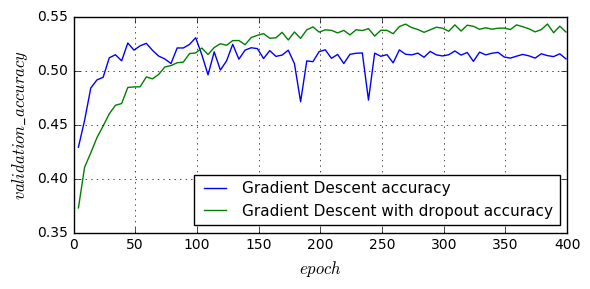

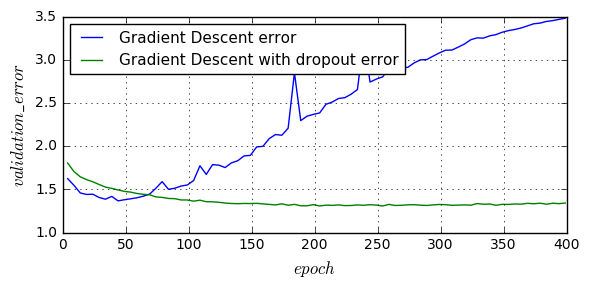

In [29]:

fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(4, 400, 5), grad_descent_valid_acc, label='Gradient Descent accuracy')
ax.plot(np.arange(4, 400, 5), dropout_validation_accs, label='Gradient Descent with dropout accuracy')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_accuracy$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('dropout_acc_comparison.pdf') 


# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(4, 400, 5), grad_descent_valid_error, label='Gradient Descent error')
ax.plot(np.arange(4, 400, 5), dropout_validation_errors, label='Gradient Descent with dropout error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('dropout_err_comparison.pdf') 

print("------  dropout  --------")
print("minimum validation error is {}".format(min(dropout_validation_errors)))
print("maximum validation accuracy is {}".format(max(dropout_validation_accs)))
print("time is {}".format(drop_out_time))